In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from scipy import sparse
import matplotlib.pyplot as plt
from ast import literal_eval
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# 1. 학습
## 1-1. 데이터 로드

In [4]:
import os
import pandas as pd
import numpy as np

class Loader:
    def __init__(self, DIR, data_no, neg_no):
        self.DIR = DIR
        self.neg_no = neg_no
        self.data_no = data_no
  
    def load_dataset(self):
        data_no = str(self.data_no)
        self.DATASET_DIR = self.DIR + 'data' + data_no

        # 데이터 로드
        self.train = pd.read_csv(os.path.join(self.DATASET_DIR, 'd'+data_no+'_train.csv'))
        self.valid_X = pd.read_csv(os.path.join(self.DATASET_DIR , 'd'+data_no+'_validation_X.csv'))
        self.valid_y = pd.read_csv(os.path.join(self.DATASET_DIR , 'd'+data_no+'_validation_y.csv'))
        self.test_X = pd.read_csv(os.path.join(self.DATASET_DIR , 'd'+data_no+'_test_X.csv'))
        self.test_y = pd.read_csv(os.path.join(self.DATASET_DIR , 'd'+data_no+'_test_y.csv'))
        self.users = pd.read_csv(os.path.join(self.DATASET_DIR , 'd'+data_no+'_users.csv'))
        self.problems = pd.read_csv(os.path.join(self.DATASET_DIR , 'd'+data_no+'_problems.csv'))
        
        # 변수
        self.users_no = len(self.users)
        self.prob_no = len(self.problems)
        self.userid2idx = {row[1]:row[0] for row in self.users.values}
        self.useridx2id = {row[0]:row[1] for row in self.users.values}
        self.probid2idx = {row[1]:row[0] for row in self.problems.values}
        self.probidx2id = {row[0]:row[1] for row in self.problems.values}
        self.useridx2level = {row[0]:row[2] for row in self.users.values}
        self.probidx2level = {row[0]:row[2] for row in self.problems.values}
        return self.users_no, self.prob_no
    
    def formatting(self, case):
        # 모델 input 형식에 맞게 바꾸기
        if case == 0:
          train = self.train_formating(self.train)
          return train
        elif case == 1: # valid
          train = self.train_formating(self.valid_X)
          test, neg = self.test_formating(self.valid_y, self.valid_X)
          return train, (test, neg)
        else: # test
          train = self.train_formating(self.test_X)
          test, neg = self.test_formating(self.test_y, self.test_X)
          return train , (test, neg)
  
    # train foramting
    def train_formating(self, dataframe):
        userId, probId, entry = [], [], []
        checked = set([(self.userid2idx[x[0]], self.probid2idx[x[1]]) for x in dataframe.values])

        neg_checked = set()

        for up in checked:
            u, p = up[0], up[1]
            # nonzero
            userId.append(u)
            probId.append(p)
            entry.append(1)

            # zero: negative sampling
            userId, probId, entry = self.negative_sampling(u, checked, neg_checked, userId, probId, entry)
        return userId, probId, entry
        
    def test_formating(self, y, pos):
      y_handle = y['handle'].apply(lambda x: self.userid2idx[x])
      y_problem = y['problemId'].apply(lambda x: literal_eval(x))
      y_problem = y_problem.apply(lambda x: [self.probid2idx[prob] for prob in x])
      df_new = pd.concat([y_handle, y_problem], axis=1)
      
      pos['handle'] = pos['handle'].apply(lambda x: self.userid2idx[x])
      pos['problemId'] = pos['problemId'].apply(lambda x: self.probid2idx[x])
      df_neg = self.get_negative_sampling(pos)
      return df_new, df_neg

    def get_negative_sampling(self, dataframe):
        
        totalProb = self.problems['problemId'].apply(lambda x: self.probid2idx[x])
        totalProb = set(totalProb.tolist())
        pos = dataframe.groupby(["handle"]).agg({'problemId': lambda x: x.tolist()}).reset_index()
        pos['problemId'] = pos['problemId'].apply(lambda x: list(totalProb-set(x)))
        df_neg = pos
        return df_neg

    # negative sampling
    def negative_sampling(self, u, checked, neg_checked, user, prob, entry):
        for n in range(self.neg_no):
            flag = False
            for t in range(20):
                p = np.random.randint(self.prob_no)
                if (u,p) not in checked and (u,p) not in neg_checked:
                    neg_checked.add((u,p))
                    flag = True
                    break
            if flag:
                user.append(u)
                prob.append(p)
                entry.append(0)
                
        return user, prob, entry

In [392]:
DIR = '/content/drive/MyDrive/(22-1)캡스톤/recomm/data/preprocessed/'
loader1 = Loader(DIR, 1, 4)
loader1.load_dataset()

(24032, 2661)

In [283]:
train = loader1.formatting(0)

In [393]:
valid_tr, valid_te  = loader1.formatting(1)
valid_te_y, valid_te_X = valid_te
test_tr, test_te  = loader1.formatting(2)
test_te_y, test_te_X = test_te

In [394]:
train_usr, train_prb, train_entry = shuffle(train[0], train[1], train[2])
train_usr = np.array(train_usr).reshape(-1,1)
train_prb = np.array(train_prb).reshape(-1,1)
train_entry = np.array(train_entry).reshape(-1,1)

In [395]:
valid_tr_usr, valid_tr_prb, valid_tr_entry = shuffle(valid_tr[0], valid_tr[1], valid_tr[2])
valid_tr_usr = np.array(valid_tr_usr).reshape(-1,1)
valid_tr_prb = np.array(valid_tr_prb).reshape(-1,1)
valid_tr_entry = np.array(valid_tr_entry).reshape(-1,1)

In [396]:
test_tr_usr, test_tr_prb, test_tr_entry = shuffle(test_tr[0], test_tr[1], test_tr[2])
test_tr_usr = np.array(test_tr_usr).reshape(-1,1)
test_tr_prb = np.array(test_tr_prb).reshape(-1,1)
test_tr_entry = np.array(test_tr_entry).reshape(-1,1)

##1-2. 모델 학습

In [397]:
import tensorflow as tf
import numpy as np
import pandas as pd

class MF(tf.keras.Model):
    def __init__(self, user_no, prob_no, K=4):
        super(MF, self).__init__()
        # 변수
        self.user_no = user_no
        self.prob_no = prob_no
        self.K = K
        self.freespace = 5

        # 레이어
        input_user = tf.keras.layers.Input(shape=(1,), dtype='int32') # 사용자 index 
        input_prob =  tf.keras.layers.Input(shape=(1,), dtype='int32') # 문제 index 
        embedding_user = tf.keras.layers.Flatten()(tf.keras.layers.Embedding(user_no+self.freespace, K)(input_user)) # [사용자 index, 잠재요인]
        embedding_prob =  tf.keras.layers.Flatten()(tf.keras.layers.Embedding(prob_no, K)(input_prob)) # [문제 index, 잠재요인]
        matmul =  tf.keras.layers.Multiply()([embedding_user, embedding_prob]) # new [사용자 index, 문제 index]
        output =  tf.keras.layers.Dense(1)(matmul)

        # 모델
        self.model = tf.keras.Model(inputs=[input_user, input_prob], outputs=output)

    def get_model(self):
        return self.model

    def load_model(self, DIR):
      return tf.keras.models.load_model(DIR)

    def level_filtering(self, usr, prb, pred, userlevel_map, problevel_map, k):
      limit = min(k*10, len(pred)-1)
      usr = np.squeeze(usr)
      prb = np.squeeze(prb)
      pred = np.squeeze(pred)
      idx = np.argpartition(-pred, limit)[:limit]

      cdUser = usr[idx]
      cdProb = prb[idx]
      cdPred = pred[idx]

      problevel = np.array([problevel_map[p] for p in cdProb])
      maxlevel = np.array([userlevel_map[u] for u in cdUser]).astype('int64')
      lam = np.mean(cdPred)/100

      dist = np.abs(np.subtract(problevel,maxlevel))*lam
      cdPred = np.subtract(cdPred, dist)
              
      top_idx = np.argsort(-cdPred)[:k]
      top_k_data = (cdUser[top_idx], cdProb[top_idx], cdPred[top_idx])
      
      return top_k_data

In [398]:
import numpy as np

def recall_at_k(X_pred, heldout, k=30):
    tp = len(set(X_pred[:k]) & set(heldout))
    if len(heldout)>0:
      recall = tp/len(heldout)
      return recall
    else:
      return 0
  
def hit_rate_at_k(X_pred, heldout, k=30):
    tp = len(set(X_pred[:k]) & set(heldout))
    if tp >= 1:
      return 1
    else:
      return 0

In [399]:
mf = MF(loader1.users_no, loader1.prob_no)
model = mf.get_model()

In [400]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss='mse')

In [375]:
train_N = len(train_usr)
valid_tr_N = len(valid_tr_usr)
valid_te_N = len(valid_te_X)
epochs = 20
batch_size = 1024
rc_vad = []
hr_vad = []
best_eval = -1
best_epoch = -1

BESTMODEL_DIR = '/content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/MF/best_model'
TRAINMODEL_DIR = '/content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/MF/train_model'

In [386]:
ct = epoch+1
model = mf.load_model(TRAINMODEL_DIR)

In [387]:
for epoch in range(ct, epochs):
  for i in range(0, train_N, batch_size):
    idxlist = range(i, min(i+batch_size, train_N-1))
    model.fit([train_usr[idxlist], train_prb[idxlist]], train_entry[idxlist], verbose=0)
  model.save(TRAINMODEL_DIR)

  for i in range(0, valid_tr_N, batch_size):
    idxlist = range(i, min(i+batch_size, valid_tr_N-1))
    model.fit([valid_tr_usr[idxlist], valid_tr_prb[idxlist]], valid_tr_entry[idxlist], verbose=0)
  
  hit_rate = 0
  recall = []
  print("validation")
  for i in range(0, valid_te_N):
    usr = valid_te_X.iloc[i,0]
    prbs = np.array(valid_te_X.iloc[i,1])
    usrs = np.array([usr]*len(prbs))
    valid_te_usr = usrs.reshape(-1,1)
    valid_te_prb = prbs.reshape(-1,1)

    pred = model.predict([valid_te_usr, valid_te_prb])
    pred = np.concatenate(pred).reshape(-1,1)
    filtered = mf.level_filtering(valid_te_usr, valid_te_prb, pred, loader1.useridx2level, loader1.probidx2level, 30)

    # valid_y
    heldout = np.array(valid_te_y.iloc[i,1])
    recall.append(recall_at_k(filtered[1], heldout, k=30))
    hit_rate += hit_rate_at_k(filtered[1], heldout, k=30)
    
  recall_ = np.mean(recall)
  rc_vad.append(recall_)
  print("epoch[", epoch, "] recall: ", recall_)

  hit_rate_ = hit_rate/valid_te_N
  hr_vad.append(hit_rate_)
  print("epoch[", epoch, "] hit rate: ", hit_rate_)
  model = mf.load_model(TRAINMODEL_DIR)

  if best_eval > 0.25:
    break

  if hit_rate_ > best_eval:
    best_eval = hit_rate_
    best_epoch = epoch
    model.save(BESTMODEL_DIR)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/MF/train_model/assets
validation
epoch[ 1 ] recall:  0.006365457720577515
epoch[ 1 ] hit rate:  0.0687089715536105
INFO:tensorflow:Assets written to: /content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/MF/train_model/assets
validation
epoch[ 2 ] recall:  0.006427959292548641
epoch[ 2 ] hit rate:  0.06958424507658643
INFO:tensorflow:Assets written to: /content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/MF/train_model/assets
validation
epoch[ 3 ] recall:  0.00644294837949036
epoch[ 3 ] hit rate:  0.06914660831509847
INFO:tensorflow:Assets written to: /content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/MF/train_model/assets
validation
epoch[ 4 ] recall:  0.006216415248143224
epoch[ 4 ] hit rate:  0.06652078774617068
INFO:tensorflow:Assets written to: /content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/MF/train_model/assets
validation
epoch[ 5 ] recall:  0.006

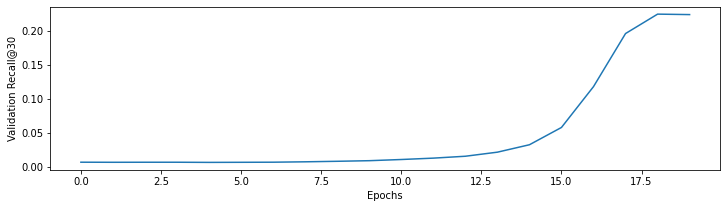

In [401]:
plt.figure(figsize=(12, 3))
plt.plot(rc_vad)
plt.ylabel("Validation Recall@30")
plt.xlabel("Epochs")
pass

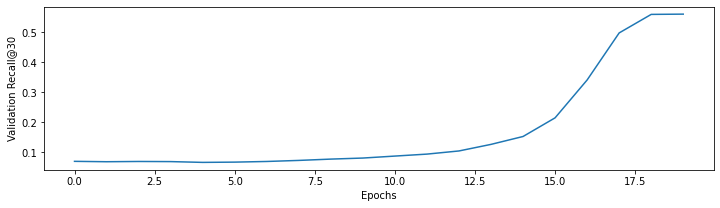

In [402]:
plt.figure(figsize=(12, 3))
plt.plot(hr_vad)
plt.ylabel("Validation Recall@30")
plt.xlabel("Epochs")
pass

# 1-3. test

In [406]:
best_model = mf.load_model(BESTMODEL_DIR)
test_tr_N = len(test_tr_usr)
test_te_N = len(test_te_X)
batch_size = 1024
test_hit_rate = 0
test_recall = []

for i in range(0, test_tr_N, batch_size):
    idxlist = range(i, min(i+batch_size, test_tr_N-1))
    model.fit([test_tr_usr[idxlist], test_tr_prb[idxlist]], test_tr_entry[idxlist], verbose=0)

for i in range(0, test_te_N):
  usr = valid_te_X.iloc[i,0]
  prbs = np.array(valid_te_X.iloc[i,1])
  usrs = np.array([usr]*len(prbs))
  test_te_usr = usrs.reshape(-1,1)
  test_te_prb = prbs.reshape(-1,1)

  pred = model.predict([test_te_usr, test_te_prb])
  pred = np.concatenate(pred).reshape(-1,1)
  filtered = mf.level_filtering(test_te_usr, test_te_prb, pred, loader1.useridx2level, loader1.probidx2level, 30)

  heldout = np.array(test_te_y.iloc[i,1])
  test_recall.append(recall_at_k(filtered[1], heldout, k=30))
  test_hit_rate += hit_rate_at_k(filtered[1], heldout, k=30)
    
print("recall: ", np.mean(test_recall))
test_hit_rate = test_hit_rate/test_te_N
print("hit rate: ", test_hit_rate)

recall:  0.004880482937217231
hit rate:  0.05820568927789934


# 2. 결과

In [ ]:
import tensorflow as tf
import pandas as pd
import os

class Result:
    def __init__(self):
        MODEL_DIR = '/content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/MF/best_model'
        DATA_DIR = '/content/drive/MyDrive/(22-1)캡스톤/recomm/data'
        
        # dataset
        self.totalUserinfo = pd.read_csv(os.path.join(DATA_DIR + "/preprocessed/", "total_user_info.csv"))
        self.problemMeta = pd.read_csv(os.path.join(DATA_DIR + "/raw_data/", "problemMeta.csv"))

        self.loader1
        self.loader2
        self.loader3
        self.loader4
        self.loader5

        # map
        self.userId2cluster = {row[0]:row[3] for row in self.totalUser.values}
        self.probId2level = {row[0]:row[5] for row in self.totalUser.values}
        self.maxLevel2cluster = dict()
        for i in range(-1,5):
          self.maxLevel2cluster[i] = 1
        for i in range(5,11):
          self.maxLevel2cluster[i] = 2
        for i in range(11,14):
          self.maxLevel2cluster[i] = 3
        for i in range(14,17):
          self.maxLevel2cluster[i] = 4
        for i in range(17,31):
          self.maxLevel2cluster[i] = 5

        # model
        self.model = tf.keras.models.load_model(MODEL_DIR)
    
    def get_maxLevel(self, probs):
      probs_level = [self.probId2level[p] for p in probs]
      return max(probs_level)

    def get_result(self, input):
        if type(input)==str: ## 회원가입된 사람
        # 1. cluster를 찾음
        # 2. id가 푼 문제를 찾음
        # 3. 형식에 맞춰 모델에 넣음 ([사용자, 문제], 클러스터 번호)
          return self.model.predict(input, self.userId2cluster[input])
        else: ## 회원가입되지 않은 사람
        # 1. cluster를 찾음
        # 2. user의 제일 끝 열 추가
        # 3. 형식에 맞춰 모델에 넣음 ([사용자, 문제], 클러스터 번호)
          return self.model.predict(input, self.userId2cluster[self.get_maxLevel(input)])        

In [ ]:
class BigModel(tf.keras.Model):
  def __init__(self):
    # model
    self.model1
    self.model2
    self.model3
    self.model4
    self.model5

  def call(input, cluster_no):
    if cluster_no == 1:
      return
    elif cluster_no == 2:
      return
    elif cluster_no == 3:
      return
    elif cluster_no == 4:
      return
    elif cluster_no == 5:
      return